In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [2]:
# Assuming that the dataset has a column named 'junction'.
# If the column name is different (e.g., 'Junction'), adjust accordingly.
df_junction1 = df[df['Junction'] == 1].reset_index(drop=True)
print("Filtered data shape (junction 1 only):", df_junction1.shape)


Filtered data shape (junction 1 only): (14592, 4)


In [3]:
import numpy as np

# Load the indices from the saved text files
train_idx = np.loadtxt("train_order_idx.txt", dtype=int)
val_idx   = np.loadtxt("val_order_idx.txt", dtype=int)
test_idx  = np.loadtxt("test_order_idx.txt", dtype=int)

# Re-create the training, validation, and test DataFrames from df_junction1
train_data = df_junction1.iloc[train_idx].reset_index(drop=True)
val_data   = df_junction1.iloc[val_idx].reset_index(drop=True)
test_data  = df_junction1.iloc[test_idx].reset_index(drop=True)

print("Train, Val, and Test sets created:")
print(" - Train data shape:", train_data.shape)
print(" - Validation data shape:", val_data.shape)
print(" - Test data shape:", test_data.shape)


Train, Val, and Test sets created:
 - Train data shape: (10214, 4)
 - Validation data shape: (1459, 4)
 - Test data shape: (2919, 4)


In [4]:
import pandas as pd

# Convert the DateTime column to datetime, if not already done
for d in [train_data, val_data, test_data]:
    d['DateTime'] = pd.to_datetime(d['DateTime'])

# Define the target column and feature columns
target_col = 'Vehicles'
# Remove target and DateTime columns from features list
feature_cols = [col for col in train_data.columns if col not in [target_col, 'DateTime']]

# Separate features and target for each split
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_val = val_data[feature_cols]
y_val = val_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# No scaling at this stage - we'll handle specific scaling later
print("Features and targets separated without scaling.")

Features and targets separated without scaling.



Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Device name: NVIDIA GeForce GTX 1050 Ti
Scaled temporal feature: year
Scaled temporal feature: day
Starting TimeSeriesTransformer training (with dummy temporal features)...
  -> Validation loss improved to 1.188954. Saving model.
Epoch 1/50 - Train Loss: 1.153341 - Val Loss: 1.188954 - Time: 9.65s
  -> Validation loss improved to 0.726808. Saving model.
Epoch 2/50 - Train Loss: 0.566203 - Val Loss: 0.726808 - Time: 7.29s
  -> Validation loss improved to 0.430779. Saving model.
Epoch 3/50 - Train Loss: 0.272843 - Val Loss: 0.430779 - Time: 6.58s
  -> Validation loss improved to 0.305689. Saving model.
Epoch 4/50 - Train Loss: 0.175929 - Val Loss: 0.305689 - Time: 6.67s
  -> Validation loss improved to 0.261588. Saving model.
Epoch 5/50 - Train Loss: 0.117301 - Val Loss: 0.261588 - Time: 6.75s
  -> Validation loss improved to 0.215832. Saving model.
Epoch 6/50 - Train Loss: 0.075714 - Val Loss: 0.215832 - Time: 6.45s
  -

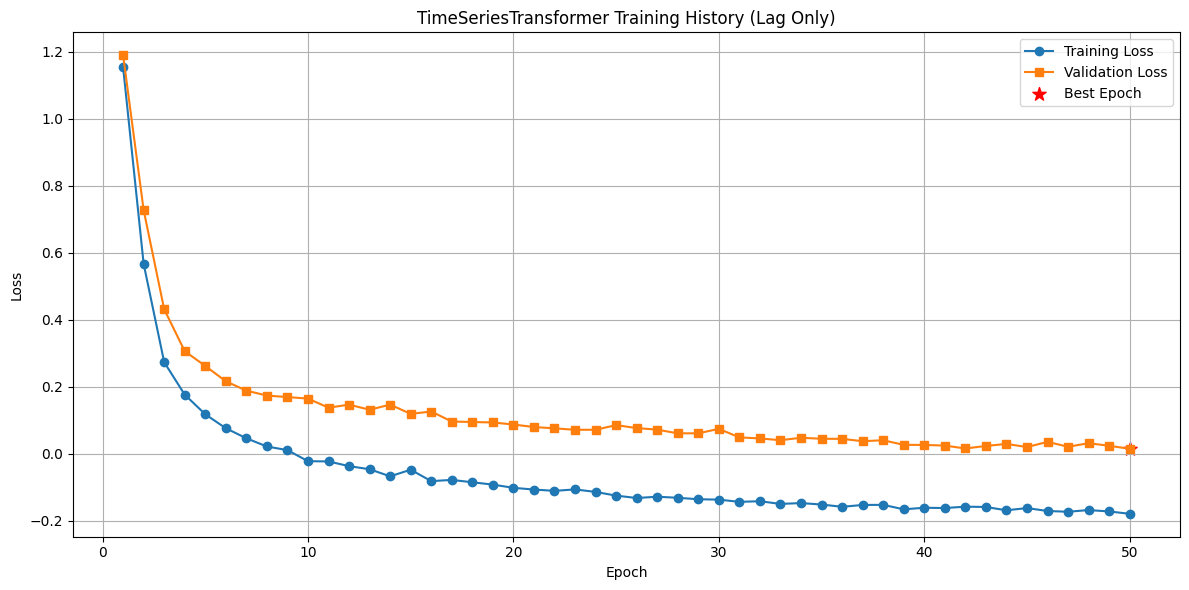


Loading best model from TimeSeriesTransformer_no_temp_model_24h for evaluation...
Best model loaded successfully.


In [5]:
# GPU setup
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Removed StandardScaler as temp_scaler is no longer needed
from sklearn.preprocessing import QuantileTransformer
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available. Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Enhanced temporal features (Function kept for sorting and feature extraction) ===
# This function and the temporal_feature_names list might be used by LATER refinement models,
# but TimeSeriesTransformer itself will not use these features in this configuration if num_time_features=0.
def extract_enhanced_datetime_features(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['day'] = df['DateTime'].dt.day
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_workday'] = (~df['is_weekend']).astype(int)
    df['morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)
    df['is_rush_hour'] = ((df['morning_rush'] | df['evening_rush']) & df['is_workday']).astype(int)
    return df

temporal_feature_names = [
    'hour_sin', 'hour_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos',
    'is_weekend', 'is_workday',
    'morning_rush', 'evening_rush', 'is_rush_hour',
]
temporal_feature_names.extend(['day', 'year'])


# === Preprocess data ===
context_length = 168
prediction_length = 24
lags_sequence = [1, 2, 3, 4, 5, 6, 7, 24, 48, 72, 96, 120, 144, 168]
max_lag = max(lags_sequence) if lags_sequence else 0

# Sort data by DateTime
train_data_sorted = extract_enhanced_datetime_features(train_data.sort_values('DateTime').reset_index(drop=True))
val_data_sorted = extract_enhanced_datetime_features(val_data.sort_values('DateTime').reset_index(drop=True))
test_data_sorted = extract_enhanced_datetime_features(test_data.sort_values('DateTime').reset_index(drop=True))

# --- Target Scaling (Only scale the target 'Vehicles') ---
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(train_data_sorted)))
scaler.fit(train_data_sorted['Vehicles'].values.reshape(-1, 1))

train_scaled_target = scaler.transform(train_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
val_scaled_target = scaler.transform(val_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
test_scaled_target = scaler.transform(test_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()

# --- Temporal Feature Scaling (Still perform this, as refinement models might use these features) ---
from sklearn.preprocessing import StandardScaler
temporal_scalers = {}
for feature_name in ['year', 'day']:
    if feature_name in temporal_feature_names:
        s = StandardScaler()
        train_data_sorted[feature_name] = s.fit_transform(train_data_sorted[[feature_name]]).flatten()
        val_data_sorted[feature_name] = s.transform(val_data_sorted[[feature_name]]).flatten()
        test_data_sorted[feature_name] = s.transform(test_data_sorted[[feature_name]]).flatten()
        temporal_scalers[feature_name] = s
        print(f"Scaled temporal feature: {feature_name}")

train_temporal_features_df = train_data_sorted[temporal_feature_names]
val_temporal_features_df = val_data_sorted[temporal_feature_names]
test_temporal_features_df = test_data_sorted[temporal_feature_names]


# --- Prepare Data for TimeSeriesTransformer (Modified to include dummy time features) ---
def prepare_timeseriestransformer_data(scaled_target_values,
                                         hist_len, pred_len, lags_seq):
    """
    Prepares data sequences for TimeSeriesTransformer.
    Includes dummy time features if num_time_features in config is 0.
    """
    max_l = max(lags_seq) if lags_seq else 0
    # For TimeSeriesTransformer, past_values fed to encoder is context_length + max_lag
    # The true context_length for the encoder part of TimeSeriesTransformer is hist_len (context_length from config)
    # The prepare_data function needs to provide hist_len + max_l for past_values if lags are used by the model internally from past_values.
    # The TimeSeriesTransformer model itself handles lag creation from past_values if lags_sequence is provided.
    # So, the input past_values should be of length context_length + max(lags_sequence).
    encoder_seq_len = hist_len + max_l
    past_values_list, past_observed_mask_list = [], []
    future_values_list = []
    # --- ADDED: Dummy time feature lists ---
    past_time_features_list, future_time_features_list = [], []


    # Total length of a sample needed from the original series
    total_sample_len = encoder_seq_len + pred_len

    for i in range(len(scaled_target_values) - total_sample_len + 1):
        # past_values for TimeSeriesTransformer should be [batch_size, context_length + max(config.lags_sequence)]
        past_vals_slice = scaled_target_values[i : i + encoder_seq_len]
        past_values_list.append(past_vals_slice)

        past_observed_mask_list.append(np.ones(encoder_seq_len, dtype=bool))

        # future_values for TimeSeriesTransformer is [batch_size, prediction_length]
        future_vals_slice = scaled_target_values[i + encoder_seq_len : i + total_sample_len]
        future_values_list.append(future_vals_slice)

        # --- ADDED: Create dummy time features (shape: seq_len, 0) ---
        # past_time_features: [batch_size, context_length + max(lags_sequence), num_time_features]
        past_time_features_list.append(np.zeros((encoder_seq_len, 0), dtype=np.float32))
        # future_time_features: [batch_size, prediction_length, num_time_features]
        future_time_features_list.append(np.zeros((pred_len, 0), dtype=np.float32))


    return (
        np.array(past_values_list),
        np.array(past_observed_mask_list),
        np.array(future_values_list),
        # --- ADDED: Return dummy time features ---
        np.array(past_time_features_list),
        np.array(future_time_features_list)
    )

# TimeSeriesTransformer does not use a 'label_length' config parameter in the same way Autoformer does.
# The teacher-forcing mechanism is standard.

# --- MODIFIED CALLS to prepare_timeseriestransformer_data ---
train_past_vals, train_mask, train_future_vals, train_past_time_dummy, train_future_time_dummy = prepare_timeseriestransformer_data(
    train_scaled_target, context_length, prediction_length, lags_sequence
)
val_past_vals, val_mask, val_future_vals, val_past_time_dummy, val_future_time_dummy = prepare_timeseriestransformer_data(
    val_scaled_target, context_length, prediction_length, lags_sequence
)
test_past_vals, test_mask, test_future_vals, test_past_time_dummy, test_future_time_dummy = prepare_timeseriestransformer_data(
    test_scaled_target, context_length, prediction_length, lags_sequence
)

# Create tensors for TimeSeriesTransformer
train_past_values_tensor = torch.tensor(train_past_vals, dtype=torch.float32).to(device)
train_observed_mask_tensor = torch.tensor(train_mask, dtype=torch.bool).to(device)
train_future_values_tensor = torch.tensor(train_future_vals, dtype=torch.float32).to(device)
# --- ADDED: Tensors for dummy time features ---
train_past_time_features_tensor = torch.tensor(train_past_time_dummy, dtype=torch.float32).to(device)
train_future_time_features_tensor = torch.tensor(train_future_time_dummy, dtype=torch.float32).to(device)


val_past_values_tensor = torch.tensor(val_past_vals, dtype=torch.float32).to(device)
val_observed_mask_tensor = torch.tensor(val_mask, dtype=torch.bool).to(device)
val_future_values_tensor = torch.tensor(val_future_vals, dtype=torch.float32).to(device)
# --- ADDED: Tensors for dummy time features ---
val_past_time_features_tensor = torch.tensor(val_past_time_dummy, dtype=torch.float32).to(device)
val_future_time_features_tensor = torch.tensor(val_future_time_dummy, dtype=torch.float32).to(device)


test_past_values_tensor = torch.tensor(test_past_vals, dtype=torch.float32).to(device)
test_observed_mask_tensor = torch.tensor(test_mask, dtype=torch.bool).to(device)
test_future_values_tensor = torch.tensor(test_future_vals, dtype=torch.float32).to(device)
# --- ADDED: Tensors for dummy time features ---
test_past_time_features_tensor = torch.tensor(test_past_time_dummy, dtype=torch.float32).to(device)
test_future_time_features_tensor = torch.tensor(test_future_time_dummy, dtype=torch.float32).to(device)


# Create dataset and dataloader (MODIFIED)
train_dataset = TensorDataset(
    train_past_values_tensor,
    train_observed_mask_tensor,
    train_future_values_tensor,
    # --- ADDED: Dummy time feature tensors to dataset ---
    train_past_time_features_tensor,
    train_future_time_features_tensor
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# === TimeSeriesTransformer Config (MODIFIED) ===
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,  # <--- Ensure this matches above
    context_length=context_length,
    input_size=1,
    lags_sequence=lags_sequence,
    num_time_features=0,
    num_dynamic_real_features=0,
    num_static_categorical_features=0,
    num_static_real_features=0,
    distribution_output="student_t",
    loss="nll",
    d_model=64,
    encoder_layers=2,
    decoder_layers=2,
    encoder_attention_heads=2,
    decoder_attention_heads=2,
    encoder_ffn_dim=128,
    decoder_ffn_dim=128,
    dropout=0.1,
    scaling=None,
    num_parallel_samples=100
)

model = TimeSeriesTransformerForPrediction(config).to(device)

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# === Training (MODIFIED model call) ===
print("Starting TimeSeriesTransformer training (with dummy temporal features)...")
best_val_loss = float('inf')
patience = 15
patience_counter = 0
epochs = 50
train_losses, val_losses, epoch_times = [], [], []
model_name = "TimeSeriesTransformer_no_temp_model_24h"

for epoch in range(epochs):
    model.train()
    epoch_start = time.time()
    epoch_loss = 0

    # --- MODIFIED: Unpack batch to include dummy time features ---
    for batch_past_vals, batch_mask, batch_future_vals, batch_past_time, batch_future_time in train_loader:
        optimizer.zero_grad()

        # --- MODIFIED: Call model WITH dummy time features ---
        # For TimeSeriesTransformer, future_observed_mask can be added if needed, defaults to all observed.
        outputs = model(
            past_values=batch_past_vals,
            past_observed_mask=batch_mask,
            past_time_features=batch_past_time,    # Pass dummy past time features
            future_values=batch_future_vals,
            future_time_features=batch_future_time    # Pass dummy future time features
        )

        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item() * batch_past_vals.size(0)

    avg_train_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Validation (MODIFIED model call)
    model.eval()
    with torch.no_grad():
        # --- MODIFIED: Call model WITH dummy time features ---
        val_outputs = model(
            past_values=val_past_values_tensor,
            past_observed_mask=val_observed_mask_tensor,
            past_time_features=val_past_time_features_tensor,    # Pass dummy past time features
            future_values=val_future_values_tensor,
            future_time_features=val_future_time_features_tensor    # Pass dummy future time features
        )
        val_loss = val_outputs.loss.item()
        val_losses.append(val_loss)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained(model_name)
        print(f"  -> Validation loss improved to {best_val_loss:.6f}. Saving model.")
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f} - Time: {epoch_time:.2f}s")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# === Summary ===
print(f"\nTraining completed in {len(train_losses)} epochs")
if val_losses: # Check if validation was performed
    best_epoch_idx = val_losses.index(min(val_losses))
    print(f"Best validation loss: {min(val_losses):.6f} at epoch {best_epoch_idx + 1}")
    print(f"Final validation loss: {val_losses[-1]:.6f}")
else:
    print("No validation losses recorded.")


# === Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
if val_losses: # Only plot validation if it exists
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='s')
    # Ensure best_epoch_idx is defined before using it
    if 'best_epoch_idx' in locals():
        plt.scatter(best_epoch_idx + 1, min(val_losses), c='red', s=100, label='Best Epoch', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TimeSeriesTransformer Training History (Lag Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Load the best model for evaluation
print(f"\nLoading best model from {model_name} for evaluation...")
# Check if the model was saved before trying to load
import os
if os.path.exists(model_name):
    model = TimeSeriesTransformerForPrediction.from_pretrained(model_name).to(device)
    print("Best model loaded successfully.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch.")
    # Keep the 'model' variable as it is (from the end of training)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Loaded best model from TimeSeriesTransformer_no_temp_model_24h for evaluation.
Generating predictions on the test set using model.generate()...
Shape of scaled predictions: (2560, 24)
Shape of original predictions: (61440,)
Shape of original targets: (61440,)

TimeSeriesTransformer Last 24h RMSE: 14.35
TimeSeriesTransformer Last 24h MAE: 11.32
TimeSeriesTransformer Last 24h R2 Score: 0.53


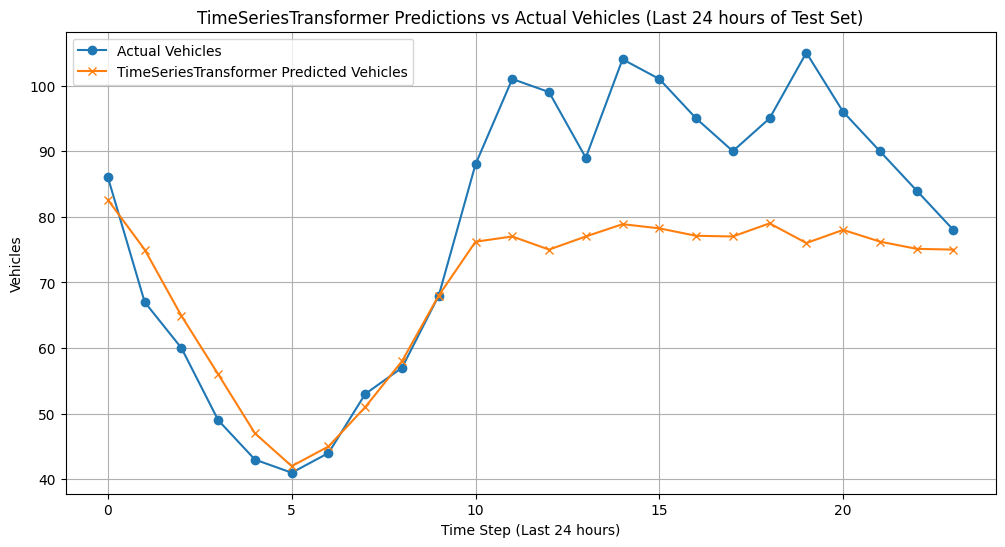

In [6]:
# === Evaluate TimeSeriesTransformer Model ===
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

# Ensure the best model is loaded (or use the last trained one if save failed)
# model_name should be defined in the previous cell (e.g., "TimeSeriesTransformer_no_temp_model")
if os.path.exists(model_name):
    # --- MODIFIED MODEL LOADING ---
    model = TimeSeriesTransformerForPrediction.from_pretrained(model_name).to(device)
    print(f"Loaded best model from {model_name} for evaluation.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch for evaluation.")
    model.to(device) # Ensure model from training is on correct device

model.eval()
all_preds_scaled = []

# For TimeSeriesTransformer's generate method, we need future_time_features for the prediction window.
# These were already prepared as test_future_time_features_tensor.

# Create a DataLoader for evaluation if the test set is large
# The test_dataset should provide all necessary inputs for model.generate()
# model.generate expects: past_values, past_time_features, past_observed_mask, future_time_features
# (and optionally static_categorical_features, static_real_features)
eval_test_dataset = TensorDataset(
    test_past_values_tensor,
    test_past_time_features_tensor,
    test_observed_mask_tensor,
    test_future_time_features_tensor # These are for the prediction horizon
)
# Reduced batch size for generate, can be GPU memory sensitive
eval_test_loader = DataLoader(eval_test_dataset, batch_size=32, shuffle=False)

print("Generating predictions on the test set using model.generate()...")
with torch.no_grad():
    for batch_past_vals, batch_past_time, batch_mask, batch_future_time_pred_window in eval_test_loader:
        # --- USE model.generate() ---
        outputs = model.generate(
            past_values=batch_past_vals,
            past_time_features=batch_past_time,
            past_observed_mask=batch_mask,
            future_time_features=batch_future_time_pred_window # Time features for the window to be predicted
            # static_categorical_features=None, # If we had them
            # static_real_features=None,     # If we had them
        )
        # outputs.sequences has shape (batch_size, num_parallel_samples, prediction_length, input_size)
        # We take the mean over num_parallel_samples (dim 1)
        # Assuming input_size=1 and prediction_length=1 for this problem
        # Squeeze to remove dimensions of size 1.
        preds = outputs.sequences.mean(dim=1).squeeze().cpu().numpy()


        # Handle cases where batch size is 1 and squeeze might remove all dims
        if preds.ndim == 0:
            preds = np.array([preds.item()])
        elif preds.ndim > 1: # If prediction_length > 1, preds might be [batch, pred_len]
            preds = preds.reshape(batch_past_vals.size(0), -1) # Flatten if necessary, or handle multi-step

        all_preds_scaled.append(preds)

timeseriestransformer_test_pred_scaled = np.concatenate(all_preds_scaled)

if timeseriestransformer_test_pred_scaled.ndim > 1 and timeseriestransformer_test_pred_scaled.shape[1] == 1:
    timeseriestransformer_test_pred_scaled = timeseriestransformer_test_pred_scaled.flatten()
# ... (rest of the prediction handling, inverse transform, metrics, plotting)
# Ensure variable names are updated e.g. timeseriestransformer_test_pred_scaled
# And y_test_orig should be derived from test_future_vals (the actual future values)
# The test_future_vals created in the previous cell are the ground truth for the scaled predictions.

print(f"Shape of scaled predictions: {timeseriestransformer_test_pred_scaled.shape}")

# Inverse transform the predictions
timeseriestransformer_test_pred_orig = scaler.inverse_transform(timeseriestransformer_test_pred_scaled.reshape(-1, 1)).flatten()
timeseriestransformer_test_pred_orig = np.clip(timeseriestransformer_test_pred_orig, 0, None)

# Get the original actual test targets corresponding to the predictions
# test_future_vals are the scaled targets for the prediction window
y_test_orig = scaler.inverse_transform(test_future_vals.reshape(-1, 1)).flatten() # test_future_vals from data prep
y_test_orig = np.clip(y_test_orig, 0, None)

print(f"Shape of original predictions: {timeseriestransformer_test_pred_orig.shape}")
print(f"Shape of original targets: {y_test_orig.shape}")

from sklearn.metrics import r2_score  # <--- ADD THIS LINE

# Ensure predictions and targets have the same length
min_len = min(len(timeseriestransformer_test_pred_orig), len(y_test_orig))
if len(timeseriestransformer_test_pred_orig) != len(y_test_orig):
    print(f"Warning: Mismatch in prediction ({len(timeseriestransformer_test_pred_orig)}) and target ({len(y_test_orig)}) lengths. Trimming to {min_len}.")
timeseriestransformer_test_pred_orig = timeseriestransformer_test_pred_orig[:min_len]
y_test_orig = y_test_orig[:min_len]

# Only compare the last 24 hours of predictions to the last 24 hours of actuals
last_n = 24  # Use prediction_length if needed

timeseriestransformer_test_pred_orig_24h = timeseriestransformer_test_pred_orig[-last_n:]
y_test_orig_24h = y_test_orig[-last_n:]

# Calculate RMSE, MAE, and R2 for TimeSeriesTransformer predictions (last 24 hours)
if len(timeseriestransformer_test_pred_orig_24h) == len(y_test_orig_24h) and len(y_test_orig_24h) > 0:
    timeseriestransformer_rmse_24h = np.sqrt(mean_squared_error(y_test_orig_24h, timeseriestransformer_test_pred_orig_24h))
    timeseriestransformer_mae_24h = mean_absolute_error(y_test_orig_24h, timeseriestransformer_test_pred_orig_24h)
    timeseriestransformer_r2_24h = r2_score(y_test_orig_24h, timeseriestransformer_test_pred_orig_24h)

    print(f"\nTimeSeriesTransformer Last 24h RMSE: {timeseriestransformer_rmse_24h:.2f}")
    print(f"TimeSeriesTransformer Last 24h MAE: {timeseriestransformer_mae_24h:.2f}")
    print(f"TimeSeriesTransformer Last 24h R2 Score: {timeseriestransformer_r2_24h:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig_24h, label='Actual Vehicles', marker='o')
    plt.plot(timeseriestransformer_test_pred_orig_24h, label='TimeSeriesTransformer Predicted Vehicles', marker='x')
    plt.title('TimeSeriesTransformer Predictions vs Actual Vehicles (Last 24 hours of Test Set)')
    plt.xlabel('Time Step (Last 24 hours)')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nCannot calculate metrics or plot: No matching predictions and targets found for the last 24 hours.")

In [8]:
# Calculate RMSE, MAE, and R2 for TimeSeriesTransformer predictions on the full test set

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure predictions and targets have the same length
min_len = min(len(timeseriestransformer_test_pred_orig), len(y_test_orig))
if len(timeseriestransformer_test_pred_orig) != len(y_test_orig):
    print(f"Warning: Mismatch in prediction ({len(timeseriestransformer_test_pred_orig)}) and target ({len(y_test_orig)}) lengths. Trimming to {min_len}.")
timeseriestransformer_test_pred_orig = timeseriestransformer_test_pred_orig[:min_len]
y_test_orig = y_test_orig[:min_len]

# Calculate metrics on the full test set
timeseriestransformer_rmse_full = np.sqrt(mean_squared_error(y_test_orig, timeseriestransformer_test_pred_orig))
timeseriestransformer_mae_full = mean_absolute_error(y_test_orig, timeseriestransformer_test_pred_orig)
timeseriestransformer_r2_full = r2_score(y_test_orig, timeseriestransformer_test_pred_orig)

print(f"\nTimeSeriesTransformer Test RMSE (full set): {timeseriestransformer_rmse_full:.2f}")
print(f"TimeSeriesTransformer Test MAE (full set): {timeseriestransformer_mae_full:.2f}")
print(f"TimeSeriesTransformer Test R2 Score (full set): {timeseriestransformer_r2_full:.2f}")


TimeSeriesTransformer Test RMSE (full set): 12.32
TimeSeriesTransformer Test MAE (full set): 8.42
TimeSeriesTransformer Test R2 Score (full set): 0.74
